In [ ]:
!pip install -q pycocotools supervision ultralytics

In [ ]:
!pip install -q pycocotools fiftyone albumentations
!pip install -q ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip' -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/2013-02-26_18_44_40_jpg.rf.8293019148cb7baa53027c24d38e27d9.jpg  
  inflating: /content/dataset/train/2013-02-26_18_49_40_jpg.rf.c1eef7b65c0ed923ae06dbb061f196ec.jpg  
  inflating: /content/dataset/train/2013-02-28_17_55_44_jpg.rf.ad44deba4e9cde52deb94231ad08fcdb.jpg  
  inflating: /content/dataset/train/2013-02-28_18_10_44_jpg.rf.936d3fd30bd7da00d27994511c6a5fac.jpg  
  inflating: /content/dataset/train/2013-02-28_18_20_45_jpg.rf.13435b67a7e0e57486133b88971ccc0a.jpg  
  inflating: /content/dataset/train/2013-02-28_18_35_45_jpg.rf.2e805c0b4ea593bd4e96cd963b7c16b2.jpg  
  inflating: /content/dataset/train/2013-02-28_18_40_45_jpg.rf.82aac71416c286b8b24b22f2c450f9b4.jpg  
  inflating: /content/dataset/train/2013-03-01_17_43_00_jpg.rf.5156dec72ce62742222ed5190f646021.jpg  
  inflating: /content/dataset/train/2013-03-01_17_53_00_jpg.rf.8f10861ebe9ce688376a83583786e9a3.jpg  
  inflating: /content/dataset/t

In [ ]:
import os

for root, dirs, files in os.walk('/content/dataset'):
    level = root.replace('/content/dataset', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:  # only show 5 files per folder
        print(f"{subindent}{f}")


dataset/
  README.dataset.txt
  README.roboflow.txt
  train/
    2012-12-26_08_30_03_jpg.rf.6fe34349106756c91fe554cc4f12591f.jpg
    2013-01-21_19_40_16_jpg.rf.06a4a5a77b79022746945c5e457a6f1f.jpg
    2013-01-21_12_20_08_jpg.rf.0812d7211506c09e2f166b9b8c7d946a.jpg
    2012-09-19_11_53_32_jpg.rf.ec9939403e0c6619399f03cbbc7dcf7d.jpg
    2012-12-08_19_00_15_jpg.rf.fb7042bebb8c007d530821d103ce2989.jpg
    labels/
      2013-03-05_17_20_13_jpg.rf.29149292e78d343022fbc60b82dcf7e6.txt
      2012-11-08_15_00_49_jpg.rf.0333213c5941097ca48a2bdac3793d1e.txt
      2012-12-07_18_42_26_jpg.rf.cefed2f22ff21e9a15ef75f4b1139d26.txt
      2013-01-19_08_35_03_jpg.rf.31abd43854069d4e35796bb0499f4279.txt
      2012-11-11_12_49_03_jpg.rf.897e65fa46f57d752d069f60b0e8ab23.txt
  test/
    2012-10-12_15_07_54_jpg.rf.c28ab85783ac5691f474d59ed68d417e.jpg
    2012-12-14_12_45_09_jpg.rf.af2440e3997dca6f63ee31a7a09d1d1b.jpg
    2012-10-28_16_02_13_jpg.rf.770688296bda24d3b7c3e22fa06b5dcf.jpg
    2012-09-16_14_33_15_j

In [ ]:
import os

folders = ['train', 'valid', 'test']
for folder in folders:
    ann_path = f'/content/dataset/{folder}/_annotations.coco.json'
    exists = os.path.exists(ann_path)
    print(f"{folder}: {'✅ Found' if exists else '❌ Not found'}")


train: ✅ Found
valid: ✅ Found
test: ✅ Found


In [32]:
dataset_yaml = """
path: /content/dataset
train: train
val: valid
test: test

nc: 3
names: ['spaces', 'space-empty', 'space-occupied']
"""

with open("/content/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

In [27]:
from pycocotools.coco import COCO
import os
from tqdm import tqdm

def convert_coco_to_yolo(coco_json_path, output_folder):
    coco = COCO(coco_json_path)
    os.makedirs(output_folder, exist_ok=True)

    # Create a map of category_id to a 0-indexed class id
    category_map = {cat['id']: idx for idx, cat in enumerate(coco.loadCats(coco.getCatIds()))}

    for img in tqdm(coco.imgs.values(), desc=f"Converting {os.path.basename(output_folder)}"):
        file_name = img['file_name']
        image_id = img['id']
        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)

        label_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + '.txt')
        with open(label_path, 'w') as f:
            for ann in anns:
                if ann['iscrowd']:
                    continue
                x, y, w, h = ann['bbox']
                xc = x + w / 2
                yc = y + h / 2
                img_w, img_h = img['width'], img['height']
                class_id = category_map[ann['category_id']]
                f.write(f"{class_id} {xc/img_w:.6f} {yc/img_h:.6f} {w/img_w:.6f} {h/img_h:.6f}\n")

# Paths
folders = ['train', 'valid', 'test']
for folder in folders:
    coco_json = f"/content/dataset/{folder}/_annotations.coco.json"
    labels_folder = f"/content/dataset/{folder}/labels"
    os.makedirs(labels_folder, exist_ok=True)
    convert_coco_to_yolo(coco_json, labels_folder)


loading annotations into memory...
Done (t=6.44s)
creating index...
index created!


Converting labels: 100%|██████████| 8691/8691 [00:02<00:00, 3391.88it/s]


loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


Converting labels: 100%|██████████| 2483/2483 [00:00<00:00, 4415.68it/s]


loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


Converting labels: 100%|██████████| 1242/1242 [00:00<00:00, 4521.26it/s]


In [28]:
import json

with open('/content/dataset/train/_annotations.coco.json') as f:
    data = json.load(f)

class_names = [cat['name'] for cat in data['categories']]
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")


  0: spaces
  1: space-empty
  2: space-occupied


In [29]:
import os
import shutil

for split in ['train', 'valid', 'test']:
    base_path = f'/content/dataset/{split}'
    os.makedirs(f'{base_path}/images', exist_ok=True)
    os.makedirs(f'{base_path}/labels', exist_ok=True)

    for file in os.listdir(base_path):
        if file.endswith(('.jpg', '.png')):
            shutil.move(os.path.join(base_path, file), os.path.join(base_path, 'images', file))
        elif file.endswith('.txt'):
            shutil.move(os.path.join(base_path, file), os.path.join(base_path, 'labels', file))


In [30]:
import os

for split in ['train', 'valid']:
    images = os.listdir(f'/content/dataset/{split}/images')
    labels = os.listdir(f'/content/dataset/{split}/labels')
    print(f"\n{split.upper()} SET:")
    print(f"Images: {len(images)}, Labels: {len(labels)}")
    missing_labels = [img for img in images if img.replace('.jpg', '.txt') not in labels]
    print(f"Missing labels for {len(missing_labels)} images")



TRAIN SET:
Images: 8691, Labels: 8691
Missing labels for 0 images

VALID SET:
Images: 2483, Labels: 2483
Missing labels for 0 images


In [33]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data="dataset.yaml",
    epochs=20,
    imgsz=640,
    batch=16
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

100%|██████████| 755k/755k [00:00<00:00, 21.7MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 106MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1221.2±518.3 MB/s, size: 61.2 KB)


train: Scanning /content/dataset/train/labels... 8691 images, 189 backgrounds, 0 corrupt: 100%|██████████| 8691/8691 [00:05<00:00, 1599.48it/s]


train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1004.3±566.4 MB/s, size: 66.2 KB)


val: Scanning /content/dataset/valid/labels... 2483 images, 59 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:02<00:00, 1186.70it/s]


val: New cache created: /content/dataset/valid/labels.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       6.3G      1.463      1.284      1.115         81        640: 100%|██████████| 544/544 [02:47<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:27<00:00,  2.88it/s]


                   all       2483     143316      0.946      0.931      0.961      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.12G      1.001     0.6323     0.9344        366        640: 100%|██████████| 544/544 [02:39<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.06it/s]


                   all       2483     143316      0.959      0.971       0.98      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.12G     0.8792     0.5462     0.8959        291        640: 100%|██████████| 544/544 [02:38<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]


                   all       2483     143316       0.92      0.955      0.987      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.94G     0.8051     0.4946     0.8774        235        640: 100%|██████████| 544/544 [02:38<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.23it/s]


                   all       2483     143316      0.961      0.976      0.992      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.78G     0.7406     0.4569     0.8619        311        640: 100%|██████████| 544/544 [02:40<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]


                   all       2483     143316      0.978      0.979      0.993      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.79G     0.6971     0.4385     0.8526        348        640: 100%|██████████| 544/544 [02:43<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.23it/s]


                   all       2483     143316      0.981      0.976      0.993      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       5.8G     0.6572     0.4102     0.8452        110        640: 100%|██████████| 544/544 [02:38<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]


                   all       2483     143316      0.982       0.98      0.993      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.82G     0.6363     0.3961     0.8406        217        640: 100%|██████████| 544/544 [02:40<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


                   all       2483     143316      0.986      0.974      0.993      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.84G     0.6134     0.3823     0.8363         67        640: 100%|██████████| 544/544 [02:38<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:26<00:00,  2.96it/s]


                   all       2483     143316      0.988      0.988      0.994      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.86G     0.5875     0.3685     0.8312        168        640: 100%|██████████| 544/544 [02:39<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.25it/s]


                   all       2483     143316      0.992      0.992      0.994      0.918
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.87G     0.5161     0.3291     0.8189         79        640: 100%|██████████| 544/544 [02:32<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.35it/s]


                   all       2483     143316      0.996      0.996      0.994      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.89G     0.4935     0.3088     0.8131        180        640: 100%|██████████| 544/544 [02:33<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


                   all       2483     143316      0.976      0.979      0.994      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.91G     0.4645     0.2948     0.8079        156        640: 100%|██████████| 544/544 [02:31<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.20it/s]


                   all       2483     143316       0.99      0.988      0.994      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.92G     0.4462     0.2841     0.8044        226        640: 100%|██████████| 544/544 [02:31<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


                   all       2483     143316      0.997      0.997      0.994      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.94G     0.4286     0.2709     0.8013         81        640: 100%|██████████| 544/544 [02:31<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:22<00:00,  3.42it/s]


                   all       2483     143316      0.998      0.998      0.994      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.96G     0.4088     0.2601     0.7981        156        640: 100%|██████████| 544/544 [02:32<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


                   all       2483     143316      0.998      0.998      0.994      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.98G     0.3965     0.2528      0.796        108        640: 100%|██████████| 544/544 [02:29<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]


                   all       2483     143316      0.998      0.998      0.994      0.956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.99G     0.3821     0.2458     0.7933        149        640: 100%|██████████| 544/544 [02:32<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.38it/s]


                   all       2483     143316      0.998      0.998      0.994      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.01G     0.3685     0.2384     0.7917        156        640: 100%|██████████| 544/544 [02:31<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.27it/s]


                   all       2483     143316      0.998      0.998      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.03G     0.3549     0.2322     0.7888        180        640: 100%|██████████| 544/544 [02:29<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.31it/s]


                   all       2483     143316      0.998      0.998      0.994      0.965

20 epochs completed in 1.006 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]


                   all       2483     143316      0.998      0.998      0.994      0.965
           space-empty       2062      73629      0.998      0.998      0.995      0.971
        space-occupied       1967      69687      0.999      0.999      0.994      0.959
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b8c0d0a44d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [38]:
from ultralytics import YOLO

model = YOLO("runs/detect/train4/weights/best.pt")

In [35]:

results = model.predict(source="/content/dataset/valid/images/2012-09-11_15_36_32_jpg.rf.b2b1767cafabff6378468d0d71c1ecd2.jpg", save=True, conf=0.25)



image 1/1 /content/dataset/valid/images/2012-09-11_15_36_32_jpg.rf.b2b1767cafabff6378468d0d71c1ecd2.jpg: 640x640 31 space-emptys, 70 space-occupieds, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train42


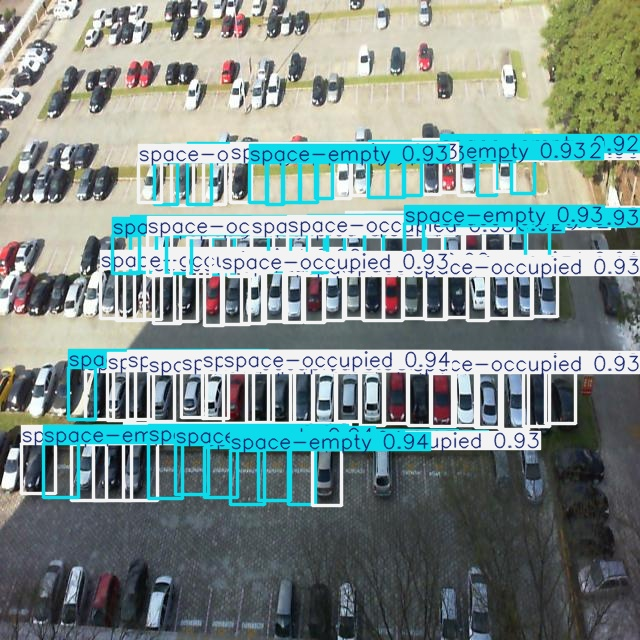

In [39]:
from IPython.display import Image

# Adjust the path depending on the output
Image(filename="runs/detect/train42/2012-09-11_15_36_32_jpg.rf.b2b1767cafabff6378468d0d71c1ecd2.jpg")